In [1]:
import torch
print("GPU Available:", torch.cuda.is_available())
print("Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

GPU Available: True
Device: NVIDIA GeForce RTX 3070 Ti Laptop GPU


In [2]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW
from torch.utils.data import DataLoader
from torch.nn import CrossEntropyLoss
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud
import torch.nn.functional as F

In [3]:
train_data = pd.read_csv("../Dataset/train_data_cleaned.csv")
val_data = pd.read_csv("../Dataset/val_data_cleaned.csv")
test_data = pd.read_csv("../Dataset/test_data_cleaned.csv")

In [4]:
def combine_text(row):
    return row["title"] + " " + row["text"]

In [5]:
train_data["content"] = train_data.apply(combine_text, axis=1)
val_data["content"] = val_data.apply(combine_text, axis=1)
test_data["content"] = test_data.apply(combine_text, axis=1)

In [6]:
encoder = LabelEncoder()
train_data["label"] = encoder.fit_transform(train_data["label"])
val_data["label"] = encoder.transform(val_data["label"])

In [7]:
# Tokenize
distilbert_tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

In [8]:
def tokenize_data(data, tokenizer, max_len=512):
    return tokenizer(
        data["content"].tolist(),
        padding="max_length",
        truncation=True,
        max_length=max_len,
        return_tensors="pt"
    )

train_encodings = tokenize_data(train_data, distilbert_tokenizer)
val_encodings = tokenize_data(val_data, distilbert_tokenizer)
test_encodings = tokenize_data(test_data, distilbert_tokenizer)

In [9]:
class FakeNewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": self.encodings["input_ids"][idx],
            "attention_mask": self.encodings["attention_mask"][idx],
            "labels": torch.tensor(self.labels[idx], dtype=torch.long),
        }

train_dataset = FakeNewsDataset(train_encodings, train_data["label"].tolist())
val_dataset = FakeNewsDataset(val_encodings, val_data["label"].tolist())
test_dataset = FakeNewsDataset(test_encodings, test_data["label"].tolist())

In [10]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

In [11]:
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=len(train_data["label"].unique())
)
model.to("cuda" if torch.cuda.is_available() else "cpu")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [12]:
optimizer = AdamW(model.parameters(), lr=5e-5)
scheduler = StepLR(optimizer, step_size=1, gamma=0.1)

c:\Users\stoic\miniconda3\envs\llms_env\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [13]:
def train_model(model, train_loader, val_loader, optimizer, scheduler, epochs=3):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    loss_fn = CrossEntropyLoss()
    train_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for batch in tqdm(train_loader):
            optimizer.zero_grad()

            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels,
            )
            loss = outputs.loss
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)
        print(f"Epoch {epoch + 1}, Training Loss: {avg_loss}")

        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["labels"].to(device)

                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                )
                predictions = torch.argmax(outputs.logits, dim=1)
                correct += (predictions == labels).sum().item()
                total += labels.size(0)

        accuracy = correct / total
        val_accuracies.append(accuracy * 100)
        print(f"Validation Accuracy: {accuracy * 100:.2f}%")
        scheduler.step()

    return train_losses, val_accuracies

In [14]:
train_losses, val_accuracies = train_model(model, train_loader, val_loader, optimizer, scheduler)

100%|██████████| 301/301 [02:21<00:00,  2.12it/s]


Epoch 1, Training Loss: 0.20784250151155598
Validation Accuracy: 96.17%


100%|██████████| 301/301 [02:14<00:00,  2.24it/s]


Epoch 2, Training Loss: 0.052937345878620236
Validation Accuracy: 97.17%


100%|██████████| 301/301 [02:15<00:00,  2.22it/s]


Epoch 3, Training Loss: 0.03120299828458466
Validation Accuracy: 97.17%


In [15]:
# Plot Training and Validation
def plot_training_progress(train_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    fig, ax1 = plt.subplots()

    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Training Loss', color='tab:red')
    ax1.plot(epochs, train_losses, color='tab:red', label='Training Loss')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Validation Accuracy (%)', color='tab:blue')
    ax2.plot(epochs, val_accuracies, color='tab:blue', label='Validation Accuracy')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    fig.tight_layout()
    plt.title('Training Loss and Validation Accuracy')
    plt.show()

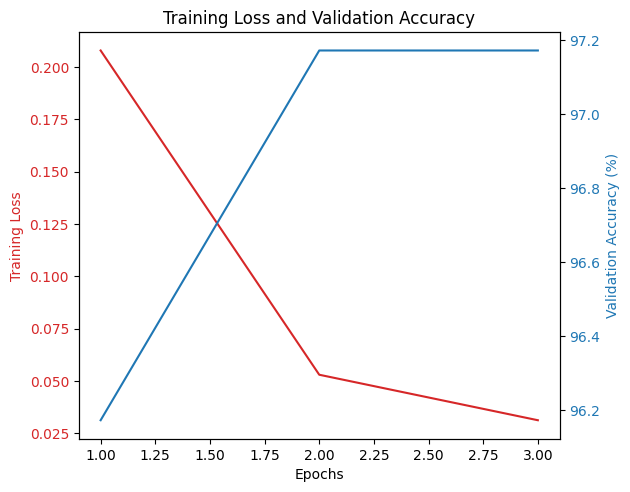

In [16]:
plot_training_progress(train_losses, val_accuracies)

In [17]:
# Evaluate Model
model.eval()
def evaluate_model_on_test_with_details(model, test_loader):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    true_labels = []
    probabilities = []
    rows_details = []

    with torch.no_grad():
        for batch in tqdm(test_loader):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            probs = F.softmax(outputs.logits, dim=1).cpu().numpy()
            predictions = np.argmax(probs, axis=1)

            probabilities.extend(probs)
            true_labels.extend(labels.cpu().numpy())

            # Collect row-by-row details
            for idx, prob in enumerate(probs):
                rows_details.append({
                    "True Label": int(labels[idx].cpu().numpy()),
                    "Predicted Label": int(predictions[idx]),
                    "Probabilities": prob.tolist(),
                })

    return probabilities, true_labels, rows_details

In [18]:
probabilities, true_labels, rows_details = evaluate_model_on_test_with_details(model, test_loader)

100%|██████████| 38/38 [00:05<00:00,  6.96it/s]


In [19]:
# Print detailed row-by-row evaluation
for row in rows_details[:5]:  # Print first 5 rows as an example
    print(row)

{'True Label': 1, 'Predicted Label': 1, 'Probabilities': [0.44961532950401306, 0.5503846406936646]}
{'True Label': 1, 'Predicted Label': 1, 'Probabilities': [0.006349135655909777, 0.9936508536338806]}
{'True Label': 0, 'Predicted Label': 0, 'Probabilities': [0.9904654026031494, 0.009534545242786407]}
{'True Label': 0, 'Predicted Label': 0, 'Probabilities': [0.9978263974189758, 0.002173561370000243]}
{'True Label': 1, 'Predicted Label': 1, 'Probabilities': [0.009568962268531322, 0.990431010723114]}


In [20]:
from sklearn.metrics import ConfusionMatrixDisplay
# Confusion Matrix
class_names = encoder.classes_
def plot_confusion_matrix(true_labels, predictions, class_names):
    cm = confusion_matrix(true_labels, predictions, labels=range(len(class_names)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title('Confusion Matrix')
    plt.show()

In [21]:
# Accuracy
accuracy = accuracy_score(true_labels, np.argmax(probabilities, axis=1))
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 97.67%


In [22]:
# Confusion Matrix
def plot_confusion_matrix(true_labels, predictions, class_names):
    cm = confusion_matrix(true_labels, predictions, labels=range(len(class_names)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title('Confusion Matrix')
    plt.show()

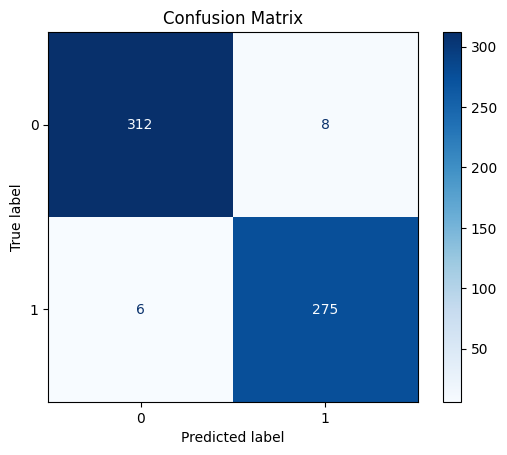

In [23]:
plot_confusion_matrix(true_labels, np.argmax(probabilities, axis=1), class_names)

In [24]:
# Precision, Recall, F1
def plot_precision_recall_f1(true_labels, predictions, class_names):
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, labels=range(len(class_names)))

    x = np.arange(len(class_names))
    width = 0.2

    plt.bar(x - width, precision, width, label='Precision', color='skyblue')
    plt.bar(x, recall, width, label='Recall', color='orange')
    plt.bar(x + width, f1, width, label='F1-Score', color='green')

    plt.xlabel('Class')
    plt.ylabel('Score')
    plt.title('Precision, Recall, and F1-Score per Class')
    plt.xticks(x, class_names, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

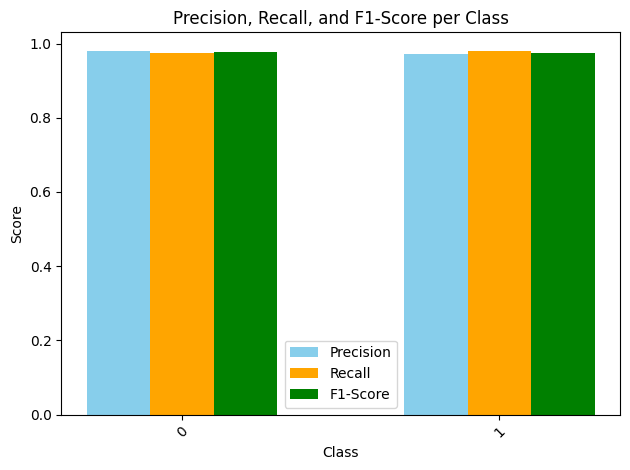

In [25]:
plot_precision_recall_f1(true_labels, np.argmax(probabilities, axis=1), class_names)

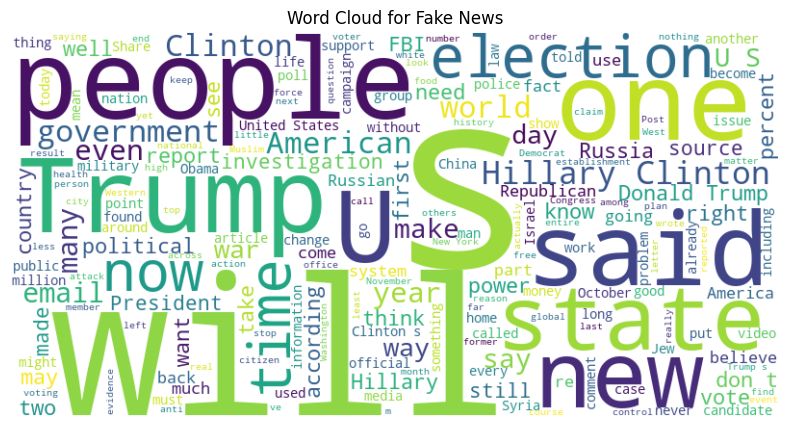

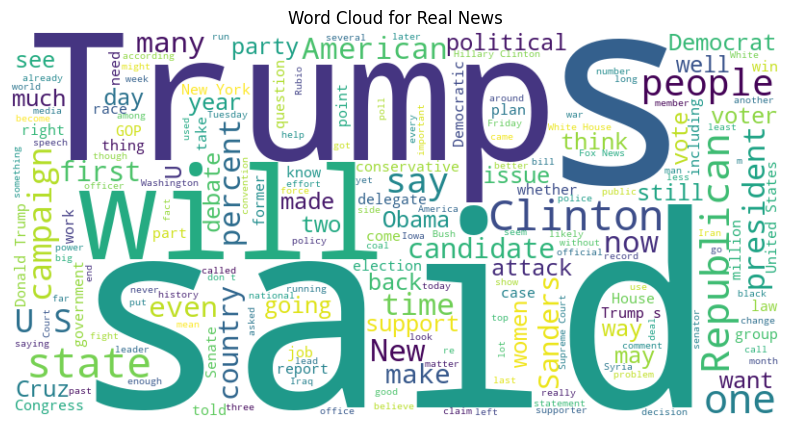

In [26]:
# Word Clouds
def generate_word_cloud(data, label_column, text_column, target_label):
    filtered_text = " ".join(data[data[label_column] == target_label][text_column])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(filtered_text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {"Fake" if target_label == 0 else "Real"} News')
    plt.show()

# Generate Word Clouds
generate_word_cloud(test_data, 'label', 'content', target_label=0)  # Fake News
generate_word_cloud(test_data, 'label', 'content', target_label=1)  # Real News

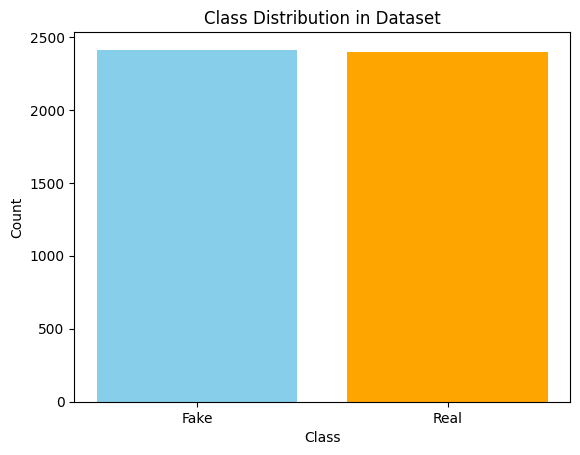

In [27]:
# Class Distribution

def plot_class_distribution(data, label_column, class_names):
    class_counts = data[label_column].value_counts()
    plt.bar(class_names, class_counts, color=['skyblue', 'orange'])
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title('Class Distribution in Dataset')
    plt.show()

plot_class_distribution(train_data, 'label', ['Fake', 'Real'])

In [28]:
# Classification Report
class_names = ['Fake', 'Real']
report = classification_report(true_labels, np.argmax(probabilities, axis=1), target_names=class_names)
print(report)

              precision    recall  f1-score   support

        Fake       0.98      0.97      0.98       320
        Real       0.97      0.98      0.98       281

    accuracy                           0.98       601
   macro avg       0.98      0.98      0.98       601
weighted avg       0.98      0.98      0.98       601



In [29]:
# ROC Curve

def plot_roc_curve(true_labels, probabilities, class_names):
    plt.figure(figsize=(8, 6))
    for i, class_name in enumerate(class_names):
        # Get true binary labels for the current class
        binary_labels = (true_labels == i).astype(int)

        # Compute ROC curve
        fpr, tpr, _ = roc_curve(binary_labels, [p[i] for p in probabilities])

        # Compute AUC
        roc_auc = auc(fpr, tpr)

        # Plot the ROC curve
        plt.plot(fpr, tpr, label=f"{class_name} (AUC = {roc_auc:.2f})")

    # Plot the diagonal line
    plt.plot([0, 1], [0, 1], color="gray", linestyle="--", label="Random Guess")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

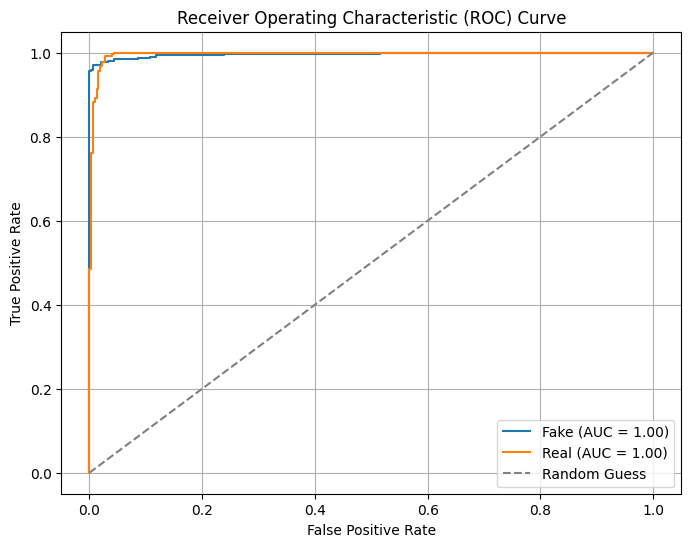

In [30]:
plot_roc_curve(np.array(true_labels), probabilities, class_names)